# **Exercise 4:** Extreme value analysis

## Estimating extreme sea levels using the Gumbel distribution to provide coastal boundary conditions

In the lecture, you were taught about ways to carry out frequency analyses, and to estimate sea levels for different return periods. You will apply the Gumbel distribution to an hourly time-series of sea levels for Charleston, SC. This includes the following steps:
1. **Download sea-level data**
2. **Pre-processing of sea-level data**  
    a. Read sea-level data  
    b. Detrend the sea level data  
5. **Extreme valye analysis**  
   a. Extract annual maxima  
    b. Fit Gumbel distribution  
   c. Calculate confidence intervals  
8. **Create design hydrographs**   

Each step is explained in more detail below.

Note that where it states `<your value>`, you will have to change the code to make it run.

### 0. Import packages

We first need to import different python packages. 

In [1]:
import os
import numpy as np              #used to work with 1d/2d/3d arrays, endless possibilities
import pandas as pd             #used to give your array a column header and row index, simplifies indexing
from pathlib import Path
import scipy.stats as sp        #used to perform statistical analysis
import matplotlib.pyplot as plt #used for making plots
from pandas.plotting import register_matplotlib_converters #used for converting between e.g. pandas timestamp/numpy datetime64/datetime.datetime

# local script used to download hourly sea levels from the NOAA database
from retrieve_water_levels import download_data 

## 1. Download sea-level data

Here you dowload the hourly sea-level data of a tide gauge station of your choice. You do this by setting the value of `station_id`. You can find this on the website of the National Oceanic and Atmospheric Administration (NOAA) Tides and Currents database (https://tidesandcurrents.noaa.gov/map/). You can also change the desired period by setting the value of `start_year` and `end_year`. 

The dowloaded data is saved in a csv file in the current directory. Watch the print messages to make sure that data is avaible for the years of your choice. 

For this exercise, we use the tide gauge Charleston, CS . Download the hourly sea-level data for the period 1980-present in .csv format by filling in the block of code below.

In [2]:
# User inputs: uncomment and fill in your values
station_name = 'Fort Pulaski, GA'
station_id = '8670870'
start_year = 1980
end_year = 2025

# complete folder path. Prefix r to produce a raw string. Without this r your folder name might be interpreted as Unicode resulting in a syntax error.
# We suggest to store the data in a folder named 'data' 
obs_folder = Path(r'../data/water_levels') 
filename = obs_folder.joinpath(f'hourly_water_levels_{station_id}.csv') #file name 

# comment out the next line if you already have the data downloaded
_ = download_data(filename, station_id=station_id, start_year=start_year, end_year=end_year, datum='NAVD')

Downloaded year 1980
Downloaded year 1981
Downloaded year 1982
Downloaded year 1983
Downloaded year 1984
Downloaded year 1985
Downloaded year 1986
Downloaded year 1987
Downloaded year 1988
Downloaded year 1989
Downloaded year 1990
Downloaded year 1991
Downloaded year 1992
Downloaded year 1993
Downloaded year 1994
Downloaded year 1995
Downloaded year 1996
Downloaded year 1997
Downloaded year 1998
Downloaded year 1999
Downloaded year 2000
Downloaded year 2001
Downloaded year 2002
Downloaded year 2003
Downloaded year 2004
Downloaded year 2005
Downloaded year 2006
Downloaded year 2007
Downloaded year 2008
Downloaded year 2009
Downloaded year 2010
Downloaded year 2011
Downloaded year 2012
Downloaded year 2013
Downloaded year 2014
Downloaded year 2015
Downloaded year 2016
Downloaded year 2017
Downloaded year 2018
Downloaded year 2019
Downloaded year 2020
Downloaded year 2021
Downloaded year 2022
Downloaded year 2023
Downloaded year 2024
Downloaded year 2025
data stored to ..\data\water_level

## 2a. Read sea-level data
The second step is to open the csv file as a so-called pandas dataframe. We open the excel file with pd.read_csv which stands for comma separated values. 

Run the first cell below. Once the asterisk sign changes into a number, the process is finished. If an error appears, check whether you correctly defined the folder path. 

At this point the dataset ranges from 1980-2022. For our analysis we want to focus on the period 1991-2020. We can easily do this by locating the rows for which the column 'datetime' index has a year value between 1990 and 2021. To do so, run the next cell and make sure to compare the printed output with the previous cell.

In [3]:
# Load the csv file with hourly sealevel time series
waterlevel = pd.read_csv(
    filename, 
    index_col=0,
    parse_dates=True,
) 
waterlevel.iloc[[0,1,2,-3,-2,-1],:]  # Print the first three and last three rows

,waterlevel
datetime,
1980-01-01 00:00:00,0.878
1980-01-01 01:00:00,0.704
1980-01-01 02:00:00,0.262
2025-12-31 21:00:00,0.678
2025-12-31 22:00:00,0.813
2025-12-31 23:00:00,0.732


In [4]:
# User inputs: uncomment and fill in your values
# Locate rows for which column value 'year' is within 1991-2020
yrmin = 1990
yrmax = 2021
waterlevel = waterlevel.loc[(waterlevel.index.year > yrmin) & (waterlevel.index.year < yrmax)] 
waterlevel[waterlevel == -32767] = np.nan                       # Change no data values to nan
waterlevel.iloc[[0,1,2,-3,-2,-1],:]                             # Print the first three and last three rows

,waterlevel
datetime,
1991-01-01 00:00:00,0.829
1991-01-01 01:00:00,0.857
1991-01-01 02:00:00,0.582
2020-12-31 21:00:00,-1.135
2020-12-31 22:00:00,-0.709
2020-12-31 23:00:00,-0.181


## 2b. Detrend sea-level data

The sea-levels are 'absolute sea-levels'. This means that the data includes sea-level rise, vertical land motion and other processes. For extreme value analysis the data needs to be stationary. Therefore, we are going to detrend the hourly sea levels. We also convert the units from mm to m. 

We will plot the data to observe the trend over the period 1991-2020. The last available date is used as reference to detrend the sea-level data. 


<u>**Q1 How much is the sea-level trend over the period 1990-2020? And is this trend sensitive to any of the settings?**<u>

Answer: In the earlier years, the sealevel reached lower points, but when adapted to the change in climate you see the band has risen slightly.

In [5]:
def lin_detrend_wNa(data, ref_date, remove_means = True, figure_plotting = True):
    """arguments:
        data is a pd.Series with date as index 
        ref_date: if a date is mentioned, remove trend taking the sealevel on this date as ref
        remove_means: if True, centers the detrended timeseries around 0
        figure_plotting: if True returns a figure of both timeseries
    returns:
        the linearly detrended data with time as index"""
     
    y = np.array(data.waterlevel) # sealevel time series
    x = np.arange(0,len(y),1)     # create x-values ranging from 0 to 1 corresponding to the sealevel timeseries (y)
    not_nan_ind = ~np.isnan(y)    # create boolean, all indexes that are not nan become 'True'
    #regression line: m=slope; b=intercept; r_val=correlation coefficient; p_val=two-sided p-value; std_err=standard error of the estimated gradient
    m, b, r_val, p_val, std_err = sp.linregress(x[not_nan_ind],y[not_nan_ind]) # see docs 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html'
   
    if remove_means == True:                          # if true, values will be centered around the mean, such that the mean of the complete time series becomes zero
        detrend_y = y - (m*x + b)                     # y = original time series; m = slope regression line; x = x-values range; b = intercept of the regression line;
    elif ref_date is not None:                        # elif ref_date is given, detrend with this date as reference point
        x_0 = np.flatnonzero(data.index == ref_date)  # index of the refdate used to detrend the complete time series
        detrend_y = y - (m*x + b) + (m * x_0 + b)     # y = original time series; m = slope regression line; x = x-values range; b = intercept of the regression line;
    else:                                             # else ref_date automatically becomes the first timestep of the time series
        detrend_y = y - (m*x)                         # y = original time series; m = slope regression line; x = x-values range;
    
    print('Linear trend is: ', m)
    
    if figure_plotting == True:
        register_matplotlib_converters()
        plt.figure()
        plt.plot(data.index, y, label = 'original')
        plt.plot(data.index, detrend_y, label = 'detrended')
        plt.xlabel('year')
        plt.ylabel('waterlevel [m]')
        plt.legend(loc='upper right')
    
    result = pd.DataFrame(data = detrend_y, index = data.index, columns=['sealevel_det']) # create a pandas dataframe with the detrended time series and dates as index
    return m,result

Linear trend is:  5.87639903619202e-07


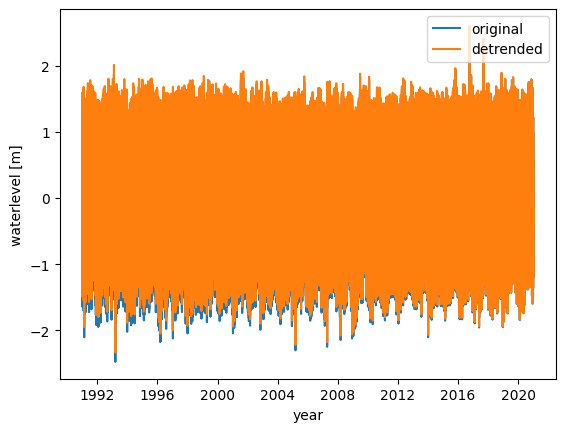

In [6]:
# Here we call the function defined in the cell above.
m,result=lin_detrend_wNa(
    waterlevel, 
    waterlevel.index[-1], 
    remove_means=False,
    figure_plotting=True
) 

In [7]:
waterlevel = pd.concat([waterlevel,result],axis=1) # Concatenates the Savannah, SC dataframe and the new detrended waterlevel
waterlevel.iloc[[0,1,2,-3,-2,-1],:]                 # Print the first three and last three rows

,waterlevel,sealevel_det
datetime,,
1991-01-01 00:00:00,0.829,0.983544
1991-01-01 01:00:00,0.857,1.011543
1991-01-01 02:00:00,0.582,0.736543
2020-12-31 21:00:00,-1.135,-1.134999
2020-12-31 22:00:00,-0.709,-0.708999
2020-12-31 23:00:00,-0.181,-0.181000


## 3a. Extract annual maxima

The annual maximum sea-levels will be stored in the variable `sl_annmax`. To get an idea of the magnitude of the annual maxima, you are going to plot them. For this you will have to write a short script yourself. Make sure you plot the `rel_sl_annmax`. While the sl_annmax values are the absolute yearly maxima, referenced to mean sea level, it is more insightful to use the mean of our timeseries as reference. 


<u>**Q2: What is the range of annual maxima? Do you see a trend in the annual maximum sea-level time-series?**<u>

Q2 answer: Annual absolute maxima are between 1.66 and 2.67 meters

In [8]:
sl_annmax = waterlevel.groupby(waterlevel.index.year)['sealevel_det'].max()                                        # extract annual maxima from the detrended sealevel time series
rel_sl_annmax = waterlevel.groupby(waterlevel.index.year)['sealevel_det'].max()-waterlevel['sealevel_det'].mean()    # subtract the mean sea level (MSL)

In [9]:
print(sl_annmax.min())
print(sl_annmax.max())

1.5911629665006297
2.601799089864658


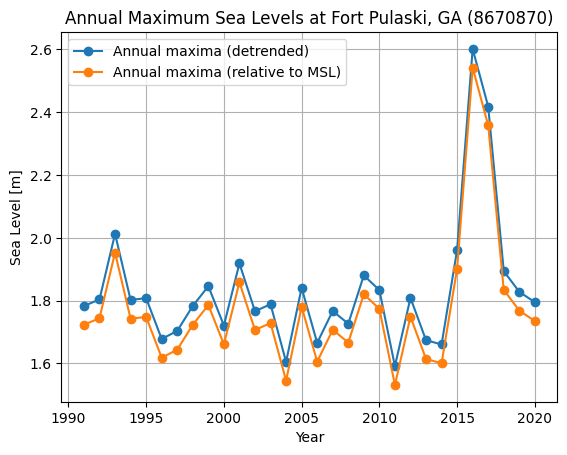

In [10]:
#Use this cell to make a plot of the annual maxima
#Check out matplotlib and its possibilities. This python library has been imported at the start of this script as 'plt'
# Make sure to include appropriate labels and also plot the absolute sea levels to check the effect of substracting the mean
plt.figure()
plt.plot(sl_annmax.index, sl_annmax.values, marker='o', label='Annual maxima (detrended)')
plt.plot(rel_sl_annmax.index, rel_sl_annmax.values, marker='o', label='Annual maxima (relative to MSL)')
plt.xlabel('Year')
plt.ylabel('Sea Level [m]')
plt.title(f'Annual Maximum Sea Levels at {station_name} ({station_id})')
plt.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'Maximum Annual Sealevel (m)')

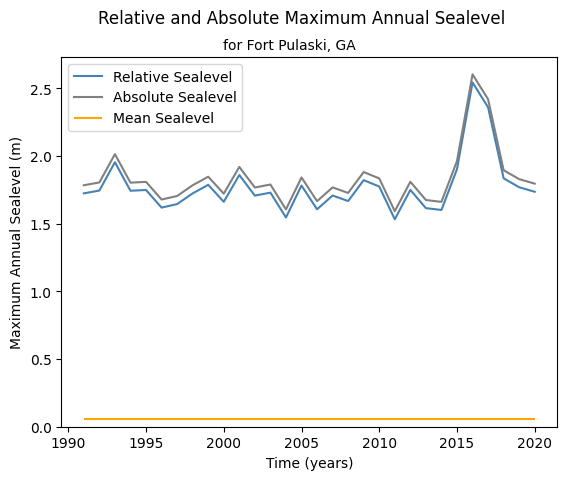

In [11]:
#Use this cell to make a plot of the annual maxima
#Check out matplotlib and its possibilities. This python library has been imported at the start of this script as 'plt'
# Make sure to include appropriate labels and also plot the absolute sea levels to check the effect of substracting the mean
import matplotlib.pyplot as plt

mean = waterlevel['sealevel_det'].mean()
xmin = rel_sl_annmax.index[0]
xmax = rel_sl_annmax.index[-1]

fig, ax = plt.subplots()
fig.suptitle(f"Relative and Absolute Maximum Annual Sealevel", fontsize=12)

ax.plot(rel_sl_annmax.index, rel_sl_annmax.values, label="Relative Sealevel", color="steelblue")
ax.plot(sl_annmax.index, sl_annmax.values, label="Absolute Sealevel", color="gray")
ax.hlines(mean, xmin, xmax, label="Mean Sealevel", color="orange")

ax.legend()
ax.set_ylim(0)
ax.set_title(f"for {station_name}         ", fontsize=10)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Maximum Annual Sealevel (m)")

## 3b. Fit a gumbel distribution to the annual maxima

Now we are ready to fit a gumbel distribution to our data. First, we calculate the location and scale parameter of our distribution by making use of the gumbel_r function that is included in the scipy.statspackage that was imported at the start of this script. Our data is right-skewed because less extreme sea levels (left side of the distribution) are more common than more extreme sea levels (right side of the distribution). Therefore we make use of the gumbel_r function. 

The next step is to rank our values from highest (rank 1) to lowest (rank 30) and compute the empirical exceedance probability. The empirical exceedance probability indicates the chance that a certain water level rank will be exceeded in any given year (x100%). By dividing 1 through the cumulative probability, we can determine the return period that belongs to each rank. 

In [12]:
### Fit Gumbel distribution
[shape,location,scale] = sp.genextreme.fit(rel_sl_annmax)  # fit the gumbel_r distribution to our data to obtain estimates of the location and scale parameter

#Step 1
rank = rel_sl_annmax.rank(axis=0, ascending=False) # rank the annual maxima
emp_exc_prob = rank/(rank.size+1)                  # empirical exceedance probabilities of the annual maxima
emp_cum_prob = 1 - emp_exc_prob                    # empirical cumalative probabilities of the annual maxima (= inverse of exceedance probability)
emp_rp = 1/emp_exc_prob                            # return periods of the annual maxima

#Step 2
cum_prob_x = np.arange(0.01,1,0.001)               # create 2d numpy array with probability range 0.01-1, with steps of 0.001
exc_prob_x = 1 - cum_prob_x                        # exceedance probabilities
rp_x=1/(exc_prob_x)                                # return periods

#Step 3
gumbel_variate = -np.log(-np.log(cum_prob_x))      # take the double log, also see 'https://en.wikipedia.org/wiki/Gumbel_distribution#Computational_methods'

#Step 4
return_periods = np.array([2,5,10,25,50,100,250,500,1000])


### Plot extreme value distribution

Below we create multiple figures that visualizes the different steps to fit a Gumbel distribution to the annual maxima. Above each figure code a short explanation about what the figure shows is provided.

<u>**Q3: What is the approximate value of relative sea-level for a 10-year return period? What about a 100-year return period? Has such an extreme event occured in the period 1990-2020?**<u>

Q3 answer: 

T10 = 1.63 --> has been exceeded 2 times

T100 = 1.86 --> has been exceeded 1 time

Estimated 10-year event: 1.9691534139492382
Estimated 100-year event: 2.2564669284566166


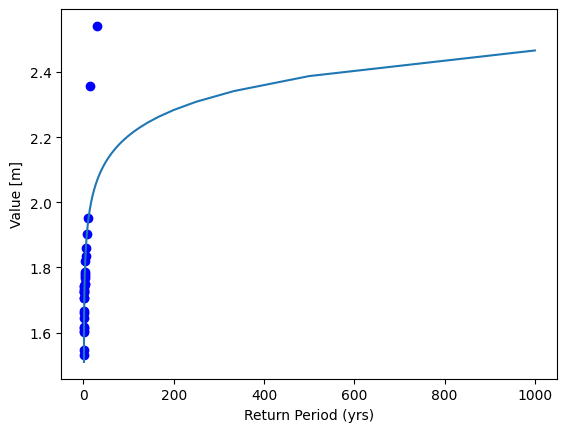

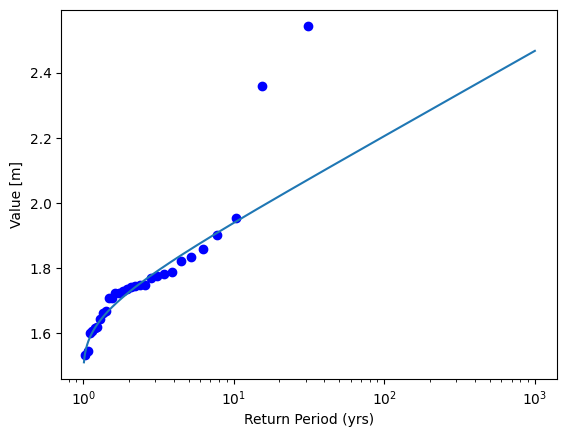

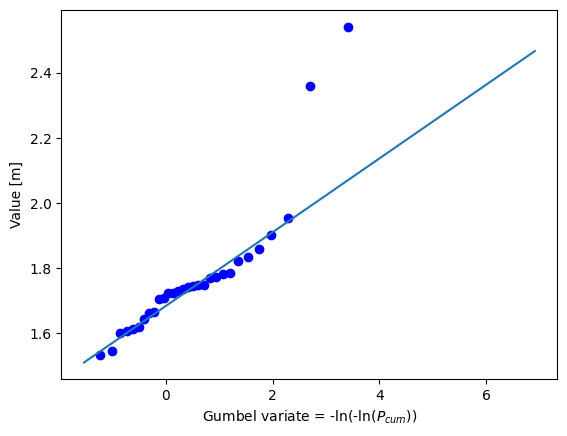

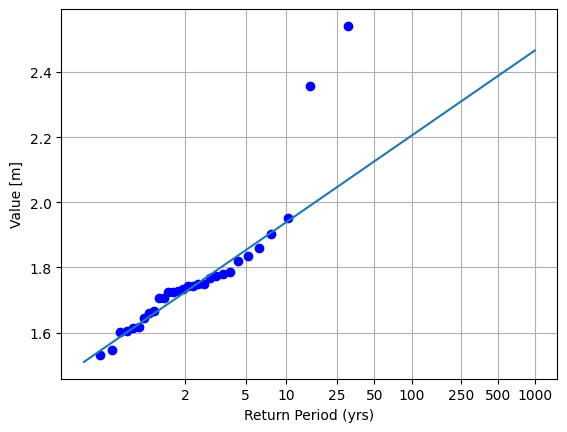

In [13]:
#Figure 1: Gumbel distribution and data plotted with normal x and y axes
plt.figure()
plt.plot(emp_rp,rel_sl_annmax,'bo')
plt.plot(rp_x,sp.gumbel_r.ppf(cum_prob_x,location,scale))
plt.xlabel('Return Period (yrs)')
plt.ylabel('Value [m]')

#Figure 2: Same as Figure 1, but now the x-axis scale is logarithmic
plt.figure()
plt.semilogx(emp_rp,rel_sl_annmax,'bo')
plt.semilogx(rp_x,sp.gumbel_r.ppf(cum_prob_x,location,scale))
plt.xlabel('Return Period (yrs)')
plt.ylabel('Value [m]')

#Figure 3: Gumbel variate on the x-axis -> double log scale used for plotting
plt.figure()
plt.plot(-np.log(-np.log(emp_cum_prob)),rel_sl_annmax, 'ob')
plt.plot(gumbel_variate,sp.gumbel_r.ppf(cum_prob_x,location,scale))
plt.xlabel('Gumbel variate = -ln(-ln($P_{cum}$))')
plt.ylabel('Value [m]')

#Figure 4: Same as Figure 3, but now the x-axis shows the return period instead of the Gumbel variate
plt.figure()
plt.plot(-np.log(-np.log(emp_cum_prob)),rel_sl_annmax, 'ob')
plt.plot(gumbel_variate,sp.gumbel_r.ppf(cum_prob_x,location,scale))
labels = [str(i) for i in return_periods]
plt.xticks(ticks = -np.log(-np.log(1 - 1/return_periods)), labels = labels)
plt.grid()
plt.xlabel('Return Period (yrs)')
plt.ylabel('Value [m]');

loc, scale = sp.gumbel_r.fit(rel_sl_annmax)

z10 = sp.gumbel_r.ppf(1 - 1/10, loc=loc, scale=scale)
z100 = sp.gumbel_r.ppf(1 - 1/100, loc=loc, scale=scale)

print("Estimated 10-year event:", z10)
print("Estimated 100-year event:", z100)


Estimated 10-year event: 1.9691534139492377
Estimated 100-year event: 2.2564669284566157

In [14]:
print("The T10 event has ben exceeded ", rel_sl_annmax[rel_sl_annmax >= 1.9691534139492377].count(), " times")
print("The T100 event has ben exceeded ", rel_sl_annmax[rel_sl_annmax >= 2.2564669284566157].count(), " times")

The T10 event has ben exceeded  2  times
The T100 event has ben exceeded  2  times


Using the code in the following cell, you can estimate the return period for sea-levels with any different return period precisely, instead of reading them from the graph above. You may adjust the requested 'return_periods' yourself.

<u>**Q4: What is the value of relative sea-level for a 100-year return period? And for a 55-year return period?**<u>

Q4 answer: 
T55 = 2.17
T100 = 2.245

In [15]:
return_periods = np.array([2,5,10,25,50,55,100,250,500,1000])
probs = 1./return_periods                                               # exceedance probabilities
rps_out = [return_periods,sp.gumbel_r.ppf(1-probs,location,scale)]      # Percent Point Function (PPF); inverse of CDF-percentiles (CDF = cumulative distribution function)
df = pd.DataFrame({'return periods (yrs)': rps_out[0],'relative sealevel (m)': rps_out[1]}) # make a dataframe of it: easier to look at the data
df

,return periods (yrs),relative sealevel (m)
0,2,1.727729
1,5,1.866316
2,10,1.958072
3,25,2.074007
4,50,2.160014
5,55,2.171780
6,100,2.245386
7,250,2.357792
8,500,2.442667
9,1000,2.527481


Importantly, in order to express the sea-level in absolute terms, we need to add the relative sea-levels to the long-term mean sea-level. This is carried out in the next cell.

<u>**Q4: What is the 100 year return period of absolute sea-level?**<u>

Q4 answer:

2.37

In [16]:
df['absolute sealevel (m)'] = df['relative sealevel (m)']+waterlevel['sealevel_det'].mean() # sum the relative sealevel and the detrended sealevel timeseries
df

,return periods (yrs),relative sealevel (m),absolute sealevel (m)
0,2,1.727729,1.787601
1,5,1.866316,1.926188
2,10,1.958072,2.017945
3,25,2.074007,2.133879
4,50,2.160014,2.219886
5,55,2.171780,2.231653
6,100,2.245386,2.305258
7,250,2.357792,2.417664
8,500,2.442667,2.502540
9,1000,2.527481,2.587354


### Other extreme value distributions
Gumbel is an example of a linear distribution which has a scale and location parameter to describe them. Most other distributions have a third parameter. Look up what other types of distributions exist. Try adjusting the lines of code below that we copied from the gumbel fitting procedure. Instead of 'gumbel_r' try fitting the 'genextreme' distribution. See the following link for more information on how to do this: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy.stats.genextreme
    
<u>**Q5: What is the name of this third parameter? Would you prefer to fit a distribution with three parameters to your sea-level data? Explain your answer.**<u>

Q5 answer: the third parameter is shape. The third parameter makes it possible to ajust to the heaviness of the tail, creating more realistic higher return periods.

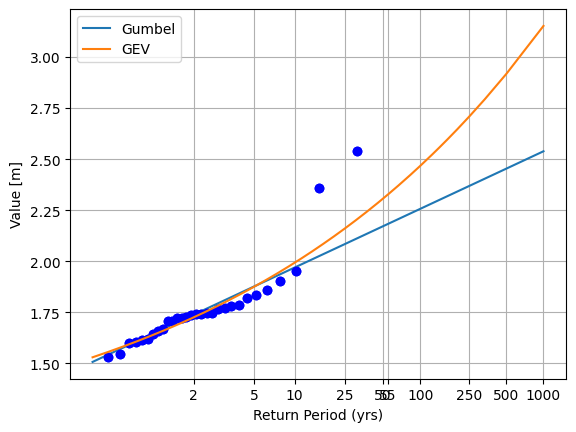

In [17]:
[location,scale] = sp.gumbel_r.fit(rel_sl_annmax)

plt.figure()
plt.plot(-np.log(-np.log(emp_cum_prob)),rel_sl_annmax, 'ob')
plt.plot(gumbel_variate,sp.gumbel_r.ppf(cum_prob_x,location,scale), label="Gumbel")
labels = [str(i) for i in return_periods]

[shape,location,scale] = sp.genextreme.fit(rel_sl_annmax)

plt.plot(-np.log(-np.log(emp_cum_prob)),rel_sl_annmax, 'ob')
plt.plot(gumbel_variate, sp.genextreme.ppf(cum_prob_x, shape, location, scale), label="GEV")
labels = [str(i) for i in return_periods]
plt.xticks(ticks = -np.log(-np.log(1 - 1/return_periods)), labels = labels)
plt.grid()
plt.xlabel('Return Period (yrs)')
plt.ylabel('Value [m]')
plt.legend()

## 3c. Calculate confidence intervals

The final step is about understanding the uncertainty associated with the estimated distribution. You will compute the 90% statistical confidence intervals of the gumbel distribution (i.e. 5th-95th percentile) using a bootstrapping approach. Bootstrapping involves the resampling a single dataset to create many simulated samples, as a way to estimate the uncertainty. This means you randomly select 30 values from the annual maxima and put each value back in the sample afterwards. This procedure is repeated 599 times following Wilcox et al. (2010). Subsequently, 599 location and scale parameters are calculated from which the 5th and 95th percentile of the parameter estimates can be extracted. Now we plot figure 4 again, including the 90% confidence interval.

When working on your own research area in a few days, we expect you to understand the uncertainty of your data. So make sure you understand the bootstrapping approach!

In [18]:
# prepare bootstrapping
nr = 599 # number of bootstrap repetitions Wilcox, R. R. (2010). Fundamentals of modern statistical methods: Substantially improving power and accuracy. Springer.
ns = rel_sl_annmax.shape[0]                       # number of annual maxima
water_levels = np.zeros((nr, cum_prob_x.size))    # array with estimated water levels
loc,sca = sp.gumbel_r.fit(rel_sl_annmax) # location and scale parameter when gumbel is fitted to annual maxima (1980-2009)
location = np.zeros((nr,))               # array with zeros
scale = np.zeros_like(location)          # array with zeros
peaks = rel_sl_annmax.values             # annual maxima


In [19]:
# perform bootstrapping
for rpi in range(nr):                                     # bootstrap for-loop (599 repetitions)
    boot = np.random.choice(peaks, size=ns, replace=True) # randomly select 30 samples from the 30 annual maxima, with replacement
    location[rpi],scale[rpi] = sp.gumbel_r.fit(boot)      # fit the gumbel distribution to obtain location and scale estimates
    water_levels[rpi, :] = sp.gumbel_r.ppf(cum_prob_x,location[rpi],scale[rpi]) # estimate water levels with fitted parrams

In [20]:
# extract 5th and 95th percentile water level estimates
water_levels5 =  np.percentile(water_levels, 5, axis = 0)
water_levels95 =  np.percentile(water_levels, 95, axis = 0)

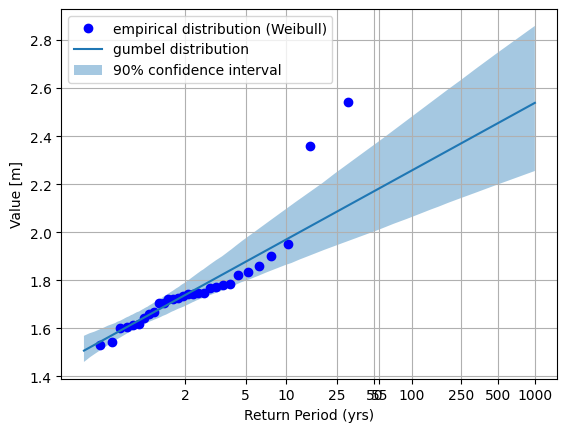

In [21]:
# plot Figure 4 again, now with the 90% confidence interval
plt.figure()
plt.plot(-np.log(-np.log(emp_cum_prob)),rel_sl_annmax, 'ob',label='empirical distribution (Weibull)')
plt.plot(gumbel_variate,sp.gumbel_r.ppf(cum_prob_x,loc,sca),label='gumbel distribution')
# fill_between takes three arguments: x; y1 (5th percentile, lower bound); y2 (95th percentile, upper bound)
# alpha makes the color transparent
plt.fill_between(gumbel_variate,water_levels5 ,water_levels95, alpha=0.4,label='90% confidence interval')
labels = [str(i) for i in return_periods]
plt.legend(loc='upper left')
plt.xticks(ticks = -np.log(-np.log(1 - 1/return_periods)), labels = labels)
plt.grid()
plt.xlabel('Return Period (yrs)')
plt.ylabel('Value [m]');

## 7. Create design hydrographs 

To force a hydrodynamic model we need a timeseries of waterlevels, not just the maximum value from the extreme value analysis.
In the next cell you will combine a simplified tidal signal with the extreme values to derive design hydrographs per return period. 

Fill in the variables `duration` and `mhw` in the code below. The duration give the duration of the surge hydrograph in hours, we will use 36 hours. The mean high water (mhw) is an estimate of the tide. You can find  this value at: https://tidesandcurrents.noaa.gov/datums.html?datum=MSL&units=1&epoch=0&id=8665530 (replace id=<station id> with your station id). To test, you can also use different values and see how it affects the hydrograph. 
    
<u>**Q6: This approach uses several assumptions about the tide and surge. Which assumptions are taken and how valid are these?**<u>

Q6 answer:

The shape of the rise and fall of the waterlevel before and after its peak is estimated and will probably not look this 'clean' during a real flood event. It is sufficient to estimate the extent of the flooding effect.

Text(0, 0.5, 'water level (m)')

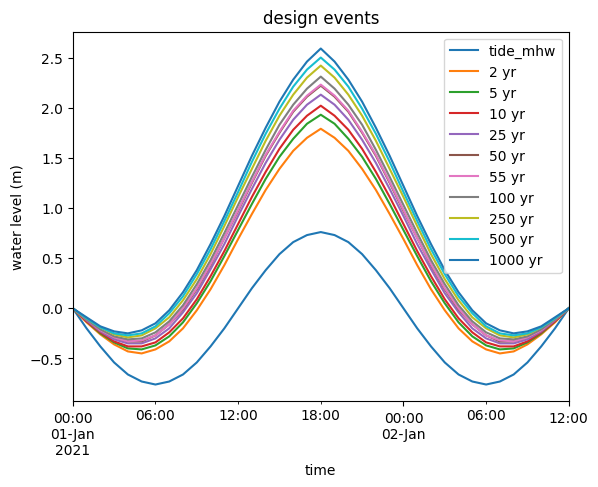

In [22]:
# User inputs: uncomment and fill in your values
duration = 36
mhw = 0.758 

# create a hydrograph based on mhw tide and triangular surge
hydrograph = pd.DataFrame(
    index = np.arange(-duration/2, duration/2+1),
    data = {
        'surge': np.zeros(duration+1),
        # tide estimate based on cosine function with amplitude of mhw and period of 12 hours
        'tide_mhw': np.cos(np.arange(-duration/2, duration/2+1)/12*np.pi)*mhw,
    }
)
hydrograph.index.name = 'time'
# create normalized triangular surge
hydrograph.loc[:0, 'surge'] = np.linspace(0,1,int(duration/2)+1)
hydrograph.loc[0:, 'surge'] = np.linspace(1,0,int(duration/2)+1)
# combine triangular surge with mhw tide
for rp in return_periods:
    htot = df['absolute sealevel (m)'].loc[df['return periods (yrs)'] == rp].values[0]
    surge = htot - mhw
    hydrograph[rp] = hydrograph['surge'] * surge + hydrograph['tide_mhw']
# remove normalized surge column
hydrograph = hydrograph.drop(columns=['surge'])

# to datetime (an actual date is required when setting the model forincg)
t0 = pd.to_datetime('2021-01-01 00:00:00') # random start time of hydrograph
hydrograph.index = pd.to_timedelta(hydrograph.index + duration/2, unit='h') + t0
hydrograph = hydrograph.round(2) # round to cm 

# save the design hydrographs and water levels to csv
hydrograph.to_csv(obs_folder.joinpath(f'design_hydrographs_{station_id}.csv'))

# plot 
hydrograph.rename(columns={rp: f'{rp} yr' for rp in return_periods}, inplace=True)
fig, ax = plt.subplots(1,1)
hydrograph.plot(ax=ax)
ax.set_title('design events')
plt.ylabel('water level (m)')


## Bonus excercise
Search for and download the COAST-RP dataset. This is a global dataset and contains return periods of total water levels. Open the dataset using xarray and search for the station that is nearest to Charleston, CS. Compare the water levels per return period. What differences do you observe? What could be the cause of this?

In [24]:
#start with something like
import xarray as xr
import numpy as np

ds = xr.open_dataset('..\data\COAST_RP\COAST-RP.nc')
ds

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sanne\AppData\Local\Temp\ipykernel_11040\3587517284.py:5: SyntaxWarning: invalid escape sequence '\d'
  ds = xr.open_dataset('..\data\COAST_RP\COAST-RP.nc')


<xarray.Dataset> Size: 5MB
Dimensions:               (stations: 23226)
Coordinates:
    station_x_coordinate  (stations) float32 93kB ...
    station_y_coordinate  (stations) float32 93kB ...
Dimensions without coordinates: stations
Data variables:
    station_id            (stations) <U40 4MB ...
    storm_tide_rp_0001    (stations) float32 93kB ...
    storm_tide_rp_0002    (stations) float32 93kB ...
    storm_tide_rp_0005    (stations) float32 93kB ...
    storm_tide_rp_0010    (stations) float32 93kB ...
    storm_tide_rp_0025    (stations) float32 93kB ...
    storm_tide_rp_0050    (stations) float32 93kB ...
    storm_tide_rp_0100    (stations) float32 93kB ...
    storm_tide_rp_0250    (stations) float32 93kB ...
    storm_tide_rp_0500    (stations) float32 93kB ...
    storm_tide_rp_1000    (stations) float32 93kB ...
Attributes: (12/15)
    title:                         COAST-RP (COastal dAtaset of Storm Tide Re...
    summary:                       Storm tide is defined as the sum of the st...
    source:                        DFLOWFM / ERA5 climate reanalysis / STORM
    model_version:                 Deltares, D-Flow FM Version 1.2.63.64757
    geospatial_lat_min:            -90
    geospatial_lat_max:            90
    ...                            ...
    geospatial_lon_units:          degrees_east
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    institution:                   IVM - VU Amsterdam
    creator_email:                 job.dullaart@vu.nl
    date_created:                  Thu Jun 3 09:42:21 2021

In [25]:
savannah_lat = 32.035
savannah_lon = -80.903

lat = ds['station_y_coordinate']
lon = ds['station_x_coordinate']


# Compute squared distance (good enough for nearest-neighbour)
dist = (lat - savannah_lat)**2 + (lon - savannah_lon)**2

# Index of nearest station
idx = dist.argmin()
idx


<xarray.DataArray ()> Size: 8B
array(18467)

In [26]:
station = ds.isel(stations=idx)
station


<xarray.Dataset> Size: 208B
Dimensions:               ()
Coordinates:
    station_x_coordinate  float32 4B -80.9
    station_y_coordinate  float32 4B 32.06
Data variables:
    station_id            <U40 160B ...
    storm_tide_rp_0001    float32 4B ...
    storm_tide_rp_0002    float32 4B ...
    storm_tide_rp_0005    float32 4B ...
    storm_tide_rp_0010    float32 4B ...
    storm_tide_rp_0025    float32 4B ...
    storm_tide_rp_0050    float32 4B ...
    storm_tide_rp_0100    float32 4B ...
    storm_tide_rp_0250    float32 4B ...
    storm_tide_rp_0500    float32 4B ...
    storm_tide_rp_1000    float32 4B ...
Attributes: (12/15)
    title:                         COAST-RP (COastal dAtaset of Storm Tide Re...
    summary:                       Storm tide is defined as the sum of the st...
    source:                        DFLOWFM / ERA5 climate reanalysis / STORM
    model_version:                 Deltares, D-Flow FM Version 1.2.63.64757
    geospatial_lat_min:            -90
    geospatial_lat_max:            90
    ...                            ...
    geospatial_lon_units:          degrees_east
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    institution:                   IVM - VU Amsterdam
    creator_email:                 job.dullaart@vu.nl
    date_created:                  Thu Jun 3 09:42:21 2021

In [27]:
import pandas as pd

rp_vars = [v for v in ds.data_vars if v.startswith("storm_tide_rp_")]

rp_values = {var: float(station[var]) for var in rp_vars}

df = pd.DataFrame.from_dict(rp_values, orient='index', columns=['water_level_m'])
df

,water_level_m
storm_tide_rp_0001,1.287
storm_tide_rp_0002,1.359
storm_tide_rp_0005,1.476
storm_tide_rp_0010,1.599
storm_tide_rp_0025,2.042
storm_tide_rp_0050,2.517
storm_tide_rp_0100,3.261
storm_tide_rp_0250,4.176
storm_tide_rp_0500,4.777
storm_tide_rp_1000,5.230


In [28]:
df['RP_years'] = df.index.str.extract(r'rp_(\d+)', expand=False).astype(int)
df = df.sort_values('RP_years')
df

,water_level_m,RP_years
storm_tide_rp_0001,1.287,1
storm_tide_rp_0002,1.359,2
storm_tide_rp_0005,1.476,5
storm_tide_rp_0010,1.599,10
storm_tide_rp_0025,2.042,25
storm_tide_rp_0050,2.517,50
storm_tide_rp_0100,3.261,100
storm_tide_rp_0250,4.176,250
storm_tide_rp_0500,4.777,500
storm_tide_rp_1000,5.230,1000


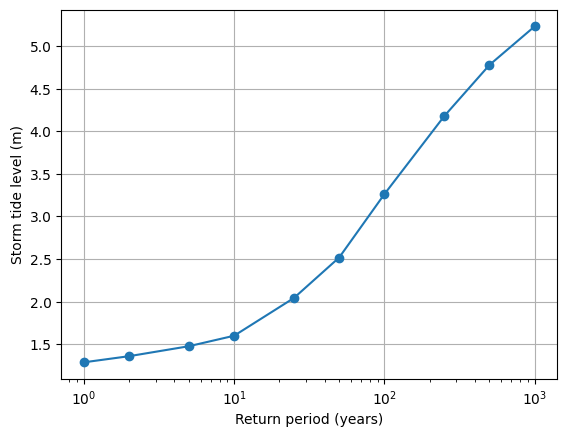

In [29]:
import matplotlib.pyplot as plt

plt.plot(df['RP_years'], df['water_level_m'], 'o-')
plt.xscale('log')
plt.xlabel("Return period (years)")
plt.ylabel("Storm tide level (m)")
plt.grid(True)

Comparison

In [30]:
import scipy.stats as sp

loc_g, scale_g = sp.gumbel_r.fit(rel_sl_annmax)

rp_list = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]
z_rp = [sp.gumbel_r.ppf(1 - 1/r, loc=loc_g, scale=scale_g) for r in rp_list]

In [31]:
import pandas as pd

df_obs = pd.DataFrame({
    'RP_years': rp_list,
    'obs_level_m': z_rp
})

In [32]:
import pandas as pd

# Collect all storm‑tide return‑period variables
rp_vars = sorted([v for v in ds.data_vars if v.startswith("storm_tide_rp_")])

# Extract values for the selected station
rp_values = {var: float(station[var]) for var in rp_vars}

# Build DataFrame
df_rp = pd.DataFrame.from_dict(rp_values, orient='index', columns=['water_level_m'])

# Extract numeric return period (0001 → 1, 0010 → 10, etc.)
df_rp['RP_years'] = df_rp.index.str.extract(r'rp_(\d+)', expand=False).astype(int)

# Sort
df_rp = df_rp.sort_values('RP_years')
df_rp

,water_level_m,RP_years
storm_tide_rp_0001,1.287,1
storm_tide_rp_0002,1.359,2
storm_tide_rp_0005,1.476,5
storm_tide_rp_0010,1.599,10
storm_tide_rp_0025,2.042,25
storm_tide_rp_0050,2.517,50
storm_tide_rp_0100,3.261,100
storm_tide_rp_0250,4.176,250
storm_tide_rp_0500,4.777,500
storm_tide_rp_1000,5.230,1000


In [33]:
import pandas as pd

# Your observational estimates
rp_list = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]
obs_levels = [sp.gumbel_r.ppf(1 - 1/r, loc=loc_g, scale=scale_g) for r in rp_list]

df_obs = pd.DataFrame({'RP_years': rp_list, 'obs_level_m': obs_levels})

# Merge with COAST-RP data
df_compare = pd.merge(df_obs, df_rp, on='RP_years')
df_compare.rename(columns={'water_level_m': 'model_level_m'}, inplace=True)
df_compare['difference_m'] = df_compare['obs_level_m'] - df_compare['model_level_m']
df_compare

,RP_years,obs_level_m,model_level_m,difference_m
0,1,-inf,1.287,-inf
1,2,1.738810,1.359,0.379810
2,5,1.877397,1.476,0.401397
3,10,1.969153,1.599,0.370153
4,25,2.085088,2.042,0.043088
5,50,2.171095,2.517,-0.345905
6,100,2.256467,3.261,-1.004533
7,250,2.368873,4.176,-1.807127
8,500,2.453748,4.777,-2.323252
9,1000,2.538562,5.230,-2.691438


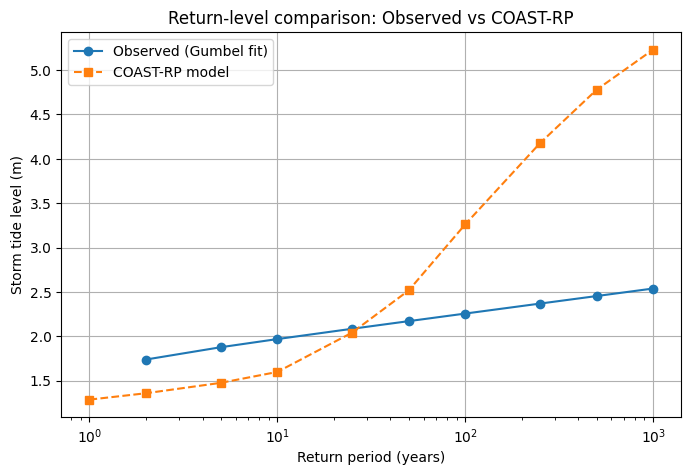

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_compare['RP_years'], df_compare['obs_level_m'], 'o-', label='Observed (Gumbel fit)')
plt.plot(df_compare['RP_years'], df_compare['model_level_m'], 's--', label='COAST-RP model')
plt.xscale('log')
plt.xlabel("Return period (years)")
plt.ylabel("Storm tide level (m)")
plt.title("Return-level comparison: Observed vs COAST-RP")
plt.grid(True)
plt.legend()
plt.show()